# 🚀 Lunar Crater Age Classification: Data Exploration
**Objective**: To systematically explore and characterize the dataset, informing preprocessing strategies and model architecture decisions for classifying craters as **"Fresh"**, **"Old"**, or **"None"**.

## 📁 1. Dataset Structure & Inventory
*Goal: Understand the organization and volume of our data.*

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from  PIL import Image
import numpy as np
import pandas as pd

In [2]:
data_path = Path("../../raw_data")

In [3]:
#Exploring the structure
print("Dataset structure:")
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}:")
    split_path = data_path / split
    for class_name in ["ejecta", "oldcrater", "none"]:
        class_path = split_path / class_name
        num_images = len(list(class_path.glob("*.jpg")))
        print(f" {class_name}: {num_images} images")

Dataset structure:

TRAIN:
 ejecta: 358 images
 oldcrater: 594 images
 none: 2656 images

VAL:
 ejecta: 55 images
 oldcrater: 118 images
 none: 440 images

TEST:
 ejecta: 89 images
 oldcrater: 157 images
 none: 533 images


## 👁️ 2. Visual Sample Gallery
*Goal: Build an intuitive, visual understanding of each class.*

In [4]:
#Create Data frame for visualization
data = []
for split in ["train", "val", "test"]:
    count = len(list((data_path / split / class_name).glob("*.jpg")))
    data.append({"split": split, "class": class_name, "count": count})
df = pd.DataFrame(data)

<Axes: xlabel='class'>

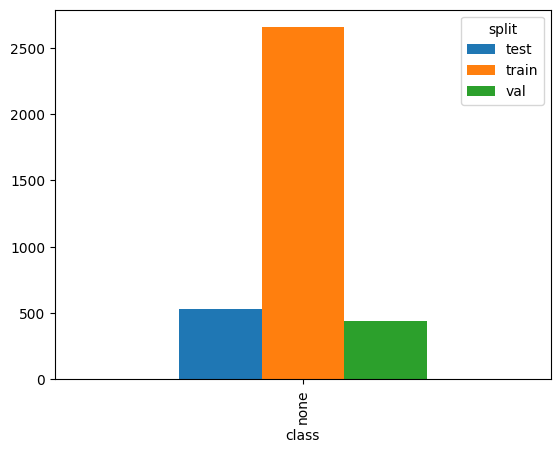

In [5]:
df.pivot(index="class", columns="split", values= "count").plot(kind="bar")

## 📐 3. Technical Image Analysis
*Goal: Determine the technical specifications and necessary transformations.*
**Key Questions:**
- What are the image dimensions (height, width)?
- What is the color mode (RGB, Grayscale)?
- What is the distribution of pixel intensities?

In [6]:
#Image dimensions
sizes = []
for class_name in ["ejecta", "oldcrater", "none"]:
    class_path = data_path / "train" / class_name
    for img_path in list(class_path.glob("*.jpg"))[:3]:
        with Image.open(img_path)as img:
            width, height = img.size
            sizes.append({"class": class_name,
                          "width": width,
                          "height": height,
                          "aspect_ratio": width/height,
                          "filename": img_path.name})
df_sizes = pd.DataFrame(sizes)

In [7]:

df_sizes

,class,width,height,aspect_ratio,filename
0,ejecta,227,227,1.0,M159705621LC_pyr-0144.jpg
1,ejecta,227,227,1.0,M1116046457RC_pyr-0593.jpg
2,ejecta,227,227,1.0,M1178246048RC_pyr-0694.jpg
3,oldcrater,227,227,1.0,M1178352512RC_pyr-0240.jpg
4,oldcrater,227,227,1.0,M1157756910LC_pyr-1398.jpg
5,oldcrater,227,227,1.0,M1095437275RC_pyr-0618.jpg
6,none,227,227,1.0,M119217559LC_pyr-0815.jpg
7,none,227,227,1.0,M1106595881LC_pyr-2050.jpg
8,none,227,227,1.0,M1178352512RC_pyr-0268.jpg


In [8]:
#Color channel investigation
pixel_stats = []
for class_name in ["ejecta", "oldcrater", "none"]:
    class_path = data_path / "train" / class_name
    for img_path in list(class_path.glob("*.jpg"))[:2]:
        with Image.open(img_path) as img:
            #Convert to numpy array for analysis
            img_array = np.array(img)
            pixel_stats.append({"class": class_name,
                                "mode": img.mode,
                                "shape": img_array.shape,
                                "min": img_array.min(),
                                "max": img_array.max(),
                                "mean": img_array.mean().round(2),
                                "std": img_array.std().round(2),
                                "dtype": img_array.dtype})

df_pixels = pd.DataFrame(pixel_stats)

In [9]:
df_pixels

,class,mode,shape,min,max,mean,std,dtype
0,ejecta,RGB,"(227, 227, 3)",25,255,154.81,28.62,uint8
1,ejecta,RGB,"(227, 227, 3)",17,196,64.41,20.90,uint8
2,oldcrater,RGB,"(227, 227, 3)",97,253,127.18,13.95,uint8
3,oldcrater,RGB,"(227, 227, 3)",0,253,99.03,20.96,uint8
4,none,RGB,"(227, 227, 3)",0,186,85.61,18.53,uint8
5,none,RGB,"(227, 227, 3)",18,215,87.88,16.72,uint8


**Image Dimensions**: All images are `227×227` pixels (confirmed via dataset documentation and sample verification).

**Implications for Preprocessing**:
- ✅ **No resizing required** - images are already uniform
- ✅ **Square aspect ratio** (1:1) - no distortion needed
- ✅ **Compatible** with common CNN architectures

**Preprocessing Decision**: We will use the native `227×227` size for our models.

**✅ Color and Pixel analysis COMPLETE:**
- **Color Mode**: All images are `RGB` (3 channels)
- **Value Range**: `[0, 255]` (uint8) → needs normalization`[0,1]` 
- **Brightness Variability**: "Ejecta" class shows high variance (64-154 mean), suggesting illumination differences

**Preprocessing Decisions:**
1. `ToTensor()` for automatic `[0,255]` → `[0,1]` conversion
2. **Normalization needed** - Will calculate exact mean/std from full dataset
3. **Color preserved** - Use all 3 RGB channels

In [10]:
#Calculate mean and std for normalization
def calculate_channel_stats(sample_size=100):
    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    count = 0

    for class_name in ["ejecta", "oldcrater", "none"]:
        class_path = data_path / "train" / class_name
        for img_path in list(class_path.glob("*.jpg"))[:sample_size//3]:
            with Image.open(img_path) as img:
                img_array = np.array(img) / 255.0     #Normalize to [0,1]
                pixel_sum += img_array.mean(axis=(0,1))
                pixel_sq_sum += (img_array**2).mean(axis=(0,1))
                count += 1

    mean = pixel_sum / count
    std = np.sqrt(pixel_sq_sum / count - mean**2)
    return mean, std

In [11]:
mean, std = calculate_channel_stats(150)
print(f"Mean per channel (R, G, B): {mean.round(4)}")
print(f"Std per channel (R, G, B): {std.round(4)}")

Mean per channel (R, G, B): [0.3306 0.3306 0.3306]
Std per channel (R, G, B): [0.1618 0.1618 0.1618]


In [12]:
#For DataLoader
normalization_stats = {"mean": list(mean.round(4)),
                       "std": list(std.round(4))}

**Calculated from 150-image sample (50 per class):**
- **Mean (R, G, B)**: `[0.3306, 0.3306, 0.3306]` -> low mean: the surface is dark gray on average
- **Standard Deviation (R, G, B)**: `[0.1618, 0.1618, 0.1618]` -> low std: Relatively low contrast accross the dataset
- **Key Insight**: Identical values across RGB channels → lunar images are effectively **grayscale**. This suggests we could potentially convert to single-channel later for efficiency.

# Data preprocessing pipeline

In [13]:
#Imports and setup
import random
import numpy as np
from pathlib import Path
from PIL import Image
from typing import List, Tuple, Dict
import json
import os

In [14]:
#Constants for exploration
IMAGE_SIZE = (227, 227)
NORM_MEAN = [0.3306, 0.3306, 0.3306]
NORM_STD = [0.1618, 0.1618, 0.1618]
CLASS_NAMES = ["ejecta", "oldcrater", "none"]

In [15]:
#---Pre processing functions---
def load_and_validate_image(path: Path) -> np.array:
    """
    Load image and ensure its 227 x 227 RGB
    Returns: Numpy array shape (227,227,3)

    Args:
        Path to the .jpg file

    Returns:
        NumPy array of shape (227, 227, 3) with dtype uint8 (0-255)
    """
    with Image.open(path) as img:
        #Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert("RGB")

        #Check size
        if img.size != IMAGE_SIZE:
            raise ValueError(f"Image {path.name} is {img.size}, expected {IMAGE_SIZE}")

        return np.array(img) #Shape (227, 227, 3), dtype: uint8

In [22]:
ejecta_path = data_path / "train" / "ejecta"
test_image_path = list(ejecta_path.glob("*.jpg"))[1]

#Call Function
image_array = load_and_validate_image(test_image_path)
#Check results:
image_array.shape, image_array.dtype, image_array.min(), image_array.max(), image_array.mean()

((227, 227, 3),
 dtype('uint8'),
 np.uint8(17),
 np.uint8(196),
 np.float64(64.41328184129326))

In [ ]:
def normalize_image(image_array: np.ndarray) -> np.array:
    """
    Applies z-score normalization to lunar crater images
    Converts [0, 255] range -> normalized range ~[-2, +2]
    Centers data around 0 (mean = 0, std = 1)
    Helps model to focus on crater features, not brightness

    Formula:
        1. Scale: img_float = img_array / 255.0
        2. Normalize: img_normalized = (img_float - 0.3306) / 0.1618

    Args:
        img_array: NumPy array from load_and_validate_image()

    Returns:
        Normalized array, shape (227, 227, 3), dtype:float32
    """

    #Convert to float32 and scale to [0, 1]
    img_float = image_array.astype(np.float32) / 255.0

     #Z-score normalization using our calculated statistics
    NORM_MEAN = 0.3306   # #Averge moon brightness (dark grey)
    NORM_STD = 0.1618    # Standard deviation of moon brightness

    return (img_float - NORM_MEAN) / NORM_STD


In [28]:
#Call normalized function
normalized_array = normalize_image(image_array)
normalized_array.shape, normalized_array.dtype, normalized_array.min(), normalized_array.max()

((227, 227, 3), dtype('float32'), np.float32(-1.631232), np.float32(2.7072155))

In [29]:
normalized_array.mean()

np.float32(-0.4820697)

In [ ]:
def preprocess_single_image(image_path: Path) -> np.array:
    """
    Complete preprocessing for one lunar image
    Combines loading, validation and normalization in one call

    Pipeline:
        1.load_and_validate_image()-
        2.normalize_image() - applies z-score normalization

    Args:
        image_path: Path to .jpg file

    Returns:
        Preprocessed image array, ready for models
        Shape: (227, 227, 3), dtype: float32
        Values normalized
    """

    #Step 1: Load and validate
    raw_image = load_and_validate_image(image_path)

    #Step 2: Normalize
    process_image = normalize_image(raw_image)

    return process_image

In [36]:
def create_balanced_subset(
    data_dir: Path,
    samples_per_class: int =358,     #Match the smallest class(ejecta)
    seed: int = 42
)->List[Tuple[Path, int]]:
    """
    Create a balance data set by downsampling the majority class.

    Args:
        data_dir: Path to folder with class subfolders (ejecta/train/none)
        samples_per_class: Number of samples per class (default to ejecta count)
        seed: Random seed for reproductibility

    Returns:
        List of(image_path, class_index) tuples
        class_index: 0=ejecta, 1=oldcrater, 2=none
    """
    random.seed(seed)
    class_names = ["ejecta", "oldcrater", "none"]
    balance_samples = []

    for class_idx, class_name in enumerate(class_names):
        class_path = data_dir / class_name
        all_files = list(class_path.glob("*.jpg"))

        if not all_files:
            raise FileNotFoundError(f"No images found in {class_path}")

        if class_name == "none":
            #Downsample majority class
            selected = random.sample(all_files, samples_per_class)
        else:
            selected = all_files[:min(samples_per_class, len(all_files))]

        balance_samples.extend([(img_path, class_idx) for img_path in selected])

    print(f"✅Balanced subset: {samples_per_class} samples per class")
    print(f"Total: {len(balance_samples)} images")
    print(f"Classes: {class_names}")

    return balance_samples

In [39]:
print("TESTING: create_balanced_subset()")
print("=" * 50)

# Test with small number
train_dir = data_path / "train"
test_samples = create_balanced_subset(train_dir, samples_per_class=5)

# Verify counts
from collections import Counter
class_counts = Counter([cls for _, cls in test_samples])
print(f"\n✅ Class distribution: {dict(class_counts)}")

TESTING: create_balanced_subset()
✅Balanced subset: 5 samples per class
Total: 15 images
Classes: ['ejecta', 'oldcrater', 'none']

✅ Class distribution: {0: 5, 1: 5, 2: 5}


In [ ]:
def preprocess_batch(
    image_paths: List[Path],
    output_dtype: type = np.float32
)->np.array:
    """
    Process multiple images efectively in batch

    Args:
        image_paths:List of paths to .jpg files
        output_dtype: Output data type (default: float32)

    Returns:
        Batch array shape: (batch_size, 227, 227 3)
        batch_size = len(image_paths)
    """
    import numpy as np
    from pathlib import Path
    from typing import List

    batch_size = len(image_paths)
    batch_array = np.zeros((batch_size, 227, 227, 3), dtype=output_dtype)

    for i, img_path in enumerate(image_paths):
        #Use our single_image function
        processed = preprocess_single_image(img_path)
        batch_array[i] = processed

    return batch_array

In [ ]:
def create_array_dataloader(
    samples: List[Tuple[Path, int]],
    batch_size: int = 32,
    shuffle: bool = True,
    seed: int = 42
):
    """
    Create a DataLoader that yields batches (more memory efficient)

    Args:
        samples: From create_balanced_subset() - list of (path, label)
        batch_size: Images per batch
        shuffle: Whether to shuffle data
        seed: Random seed

    Yields:
        (batch_images, batch_labels) per iteration
        - batch_images: shape (batch_size, 227, 227, 3), float32
        - batch_labels: shape (batch_size,), int32
    """
    import random
    import numpy as np
    from typing import List, Tuple
    from pathlib import Path

    random.seed(seed)

    if shuffle:
        random.shuffle(samples)

    # Separate paths and labels
    image_paths = [item[0] for item in samples]
    labels = np.array([item[1] for item in samples], dtype=np.int32)

    n_samples = len(samples)

    # Yield batches
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)

        batch_paths = image_paths[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Process this batch
        batch_images = preprocess_batch(batch_paths)

        yield batch_images, batch_labels

In [48]:
def create_weighted_sampler(
    samples: List[Tuple[Path, int]],
    seed: int = 42
)->List[Tuple[Path, int]]:
    """
    Creates a weighted dataset to handle class imbalance.
    Oversamples minority classes by duplicating samples based on class weights.
    Returns a resampled list with balanced class distribution

    Args:
        samples: List of (image_path, class_label) tuples
        seed: Random seed for reproducibility
    """

    random.seed(seed)

    #Extract labels from samples
    labels = [label for _, label in samples]

    #Count samples per class
    class_counts = Counter(labels)
    class_names = ["ejecta", "oldcrater", "none"]

    print(f"Original class distribution:")
    for class_idx in sorted(class_counts.keys()):
        class_name = class_names[class_idx]
        count = class_counts[class_idx]
        print(f"{class_name}: {count} samples")

    #Calculate target number of samples per class (largest class)
    max_samples = max(class_counts.values())

    #Calculate weights: target / current count
    weights = {}
    resampled_samples = []

    for class_idx in sorted(class_counts.keys()):
        class_name = class_names[class_idx]
        class_samples = [s for s in samples if s[1] == class_idx]

        #weigth how many times we need to replicate
        weight = max_samples / len(class_samples)

        #determine ho many samples to add
        num_needed = max_samples - len(class_samples)

        if num_needed > 0:
            #Randomly select samples ro duplicate
            additional_samples = random.choices(class_samples, k = num_needed)

            #Combine original + additional samples
            resampled_class = class_samples + additional_samples
        else:
            #If already has max_samples, just use existing ones
            resampled_class = class_samples

        weights[class_idx] = weight
        resampled_samples.extend(resampled_class)

    #Shiffle the resampled dataset
    random.shuffle(resampled_samples)

    #Count final distribution
    final_counts = Counter([label for _, label in resampled_samples])
    print(f"After weighted resampling")
    for class_idx in sorted(final_counts.keys()):
        class_name = class_names[class_idx]
        count = final_counts[class_idx]
        weight = weights.get(class_idx, 1.0)
        print(f"{class_name}: {count} samples (weight: {weight:.2f})")

    return resampled_samples


In [ ]:
# Quick test in Python interpreter
from collections import Counter

# Create test data
test_samples = []
for i in range(3):  # ejecta
    test_samples.append((Path(f"ejecta_{i}.jpg"), 0))
for i in range(5):  # oldcrater
    test_samples.append((Path(f"oldcrater_{i}.jpg"), 1))
for i in range(10):  # none
    test_samples.append((Path(f"none_{i}.jpg"), 2))

print("Before:")
labels_before = [label for _, label in test_samples]
print(Counter(labels_before))

print("\nAfter weighted sampling:")
resampled = create_weighted_sampler(test_samples, seed=42)
labels_after = [label for _, label in resampled]
print(Counter(labels_after))

print(f"\nAll classes should have 10 samples (largest class)")
print(f"Total samples went from {len(test_samples)} to {len(resampled)}")

Before:
Counter({2: 10, 1: 5, 0: 3})

After weighted sampling:
Original class distribution:
ejecta: 3 samples
oldcrater: 5 samples
none: 10 samples
After weighted resampling
ejecta: 10 samples (weight: 3.33)
oldcrater: 10 samples (weight: 2.00)
none: 10 samples (weight: 1.00)
Counter({1: 10, 2: 10, 0: 10})

All classes should have 10 samples (largest class)
Total samples went from 18 to 30


In [ ]:
def load_data(
    data_dir: Path,
    balanced: bool = True,
    batch_size: int = 32,
    use_weighted_sampling: bool = False,
    samples_per_class: int = 358,
    seed: int = 42
) ->Generator[Tuple[np.array, np.ndarray], None, None]:
    """
    MAIN FUNCTION- What we should use for loading data

    Loads and batches lunar crater images for training/validation.

    Args:
        data_dir: Path to data folder
        balanced: True for balanced subset (prototype), false for all data (Final training)
        use_weighted_sampling: Apply weighted sampling for imbalance data (only works when balanced = false)
        batch_size: Number of images per batch
        samples_per_class: For balanced mode only
        seed: Random seed for reproducibility

    Returns:
        Generator yielding (images, labels) batches

    """

    if balanced:
        print(f"Creating BALANCED dataset ({samples_per_class} per class)")
        samples = create_balanced_subset(data_dir, samples_per_class, seed)
        print (f"Total images: {len(samples)}")

        #Create loader for balanced data
        loader = create_array_dataloader(samples, batch_size=batch_size, shuffle=True, seed=seed)

    else:
        print(f"Creating FULL dataset (all available data)")
        samples = []
        class_names = ["ejecta", "oldcrater", "none"]

        for class_idx, class_name in enumerate(class_names):
            class_path = data_dir / class_name
            all_files = list(class_path.glob("*.jpg"))
            samples.extend([(img_path, class_idx) for img_path in all_files])

            print(f"{class_name}: {len(all_files)} images")

        print(f"Total images {len(samples)}")

        if use_weighted_sampling:
            print(f"Applying weighted sampling strategy")
            #Resample the entire dataset with weights
            resampled_samples = create_weighted_sampler(samples, seed=seed)
            loader = create_array_dataloader(resampled_samples, batch_size=batch_size, shuffle=True, seed=seed)

        else:
            #Standard imbalanced loader
            print(f"Using imbalanced data without weighting")
            loader = create_array_dataloader(samples, batch_size=batch_size, shuffle=True, seed=seed)

    #Create a data loader
    loader = create_array_dataloader(samples, batch_size=batch_size, shuffle= True, seed=seed)

    return loader
